In [1]:
!pip install transformers qdrant_client datasets torch sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1

In [2]:
from sentence_transformers import SentenceTransformer
from PIL import Image
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch

In [3]:
#connect to the vector database --> get those here :https://cloud.qdrant.io/
from google.colab import userdata
qdrant_url = userdata.get('qdrant_url')
qdrant_api_key =  userdata.get('qdrant_api_key')


client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key
     )

In [4]:
# create collection
my_collection = "image_collection_test"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

## 3. Image Embeddings

In [5]:
# get the data
dataset = load_dataset(
     'ashraq/fashion-product-images-small', split='train[:20000]'
)

values= list(range(len(dataset)))
dataset=dataset.add_column('image_id',values)

dataset_test = load_dataset(
     'ashraq/fashion-product-images-small', split='train[20000:30000]'
)

values= list(range(len(dataset_test)))
dataset_test=dataset_test.add_column('image_id',values)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

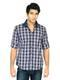

In [26]:
dataset[0]['image']

In [6]:
#use this if image is in url format.
def download_image(url):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    image = PILImage.open(response.raw)
    return image

def to_pillow(examples):
    urls = examples['Photo']
    images = [download_image(url) for url in urls]
    examples['image'] = images
    return examples
#dataset_train = dataset_train.map(to_pillow, batched=True)
#dataset_test = dataset_test.map(to_pillow, batched=True)

In [7]:
#embedding model
model = SentenceTransformer("clip-ViT-B-32")

In [8]:
# Define a function to encode images and add embeddings to the dataset
def add_embeddings(example):
    image = example['image']
    image_embedding = model.encode(image).tolist()
    example['embeddings'] = image_embedding
    return example

# Apply the function to each example in the dataset
dataset = dataset.map(add_embeddings)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [9]:
payload = dataset.select_columns(['id','gender','masterCategory', 'subCategory',
                                  'articleType', 'baseColour', 'season', 'year',
                                  'usage', 'productDisplayName', 'image_id'
]).to_pandas().fillna({"age": 0}).to_dict(orient="records")

payload[5]

{'id': 1855,
 'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Tshirts',
 'baseColour': 'Grey',
 'season': 'Summer',
 'year': 2011.0,
 'usage': 'Casual',
 'productDisplayName': 'Inkfruit Mens Chain Reaction T-shirt',
 'image_id': 5}

In [10]:
ids = list(range(dataset.num_rows))
embeddings =np.array(dataset['embeddings']).tolist()

In [24]:
embeddings[111]

[-0.12518367171287537,
 0.014599472284317017,
 -0.20226937532424927,
 0.33655861020088196,
 0.06852993369102478,
 0.032963335514068604,
 -0.5273772478103638,
 -0.13501712679862976,
 -0.12418454885482788,
 0.3365367650985718,
 0.006937623023986816,
 0.21866290271282196,
 0.17644484341144562,
 0.07553999125957489,
 -0.3668082058429718,
 -0.0545465350151062,
 0.29085487127304077,
 0.49897581338882446,
 -0.274735689163208,
 -0.6132993698120117,
 -0.3128337860107422,
 -0.4427529573440552,
 0.4076196253299713,
 -0.13005200028419495,
 0.10771232843399048,
 0.18330685794353485,
 -0.2594352662563324,
 -0.26802095770835876,
 0.04473137855529785,
 0.020385917276144028,
 0.3141254186630249,
 -0.10854049026966095,
 0.19566568732261658,
 -0.17018486559391022,
 -0.19274798035621643,
 -0.3854113817214966,
 0.06099071726202965,
 -0.177744060754776,
 -0.2518213093280792,
 1.1220307350158691,
 -0.1652711033821106,
 -0.4238063097000122,
 -0.2959809899330139,
 -0.3866426348686218,
 0.0030493885278701782,
 

We are now ready to upsert the combination of ids, vectors and payload to our collection, and we'll do so in batches of 1000.

In [12]:
batch_size = 1000

for i in range(0, dataset.num_rows, batch_size):

    low_idx = min(i+batch_size, dataset.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

We can make sure our vectors were uploaded successfully by counting them with the `client.count()` method.

In [13]:
client.count(
    collection_name=my_collection,
    exact=True,
)

CountResult(count=20000)

To visually inspect the collection we just created, we can scroll through our vectors with the `client.scroll()` method.

In [15]:
collection_info = client.get_collection(collection_name='image_collection_test')
list(collection_info)

[('status', <CollectionStatus.YELLOW: 'yellow'>),
 ('optimizer_status', <OptimizersStatusOneOf.OK: 'ok'>),
 ('vectors_count', 22000),
 ('indexed_vectors_count', 10000),
 ('points_count', 22000),
 ('segments_count', 3),
 ('config',
  CollectionConfig(params=CollectionParams(vectors=VectorParams(size=512, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None)),
 ('payload_schema', {})]

{'id': 49613, 'gender': 'Women', 'masterCategory': 'Footwear', 'subCategory': 'Shoes', 'articleType': 'Heels', 'baseColour': 'Multi', 'season': 'Winter', 'year': 2015.0, 'usage': 'Casual', 'productDisplayName': 'Catwalk Women Multi Coloured Heels', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7CF7D4F5BBB0>, 'image_id': 397}


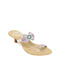

In [48]:
image = dataset_test[397]['image']
image_embedding = model.encode(image)
payload_dict = dataset_test[397]
print(payload_dict)
image

In [43]:
from qdrant_client.http import models

filter_on_masterCategory = models.Filter(
    must=[
        models.FieldCondition(key="masterCategory", match=models.MatchValue(value=payload_dict['masterCategory'])),
        models.FieldCondition(key="baseColour", match=models.MatchValue(value=payload_dict['baseColour'])),
    ]
)

In [49]:
search_results = client.search(
    collection_name=my_collection,
    query_vector=image_embedding.tolist(),
    #query_filter=filter_on_masterCategory,
    #score_threshold=0.92,
    limit=10
)


scored_points_list = []
for scored_point in search_results:
    scored_point_dict = {
        "id": scored_point.id,
        "version": scored_point.version,
        "score": scored_point.score,
        "payload": scored_point.payload,
        "vector": scored_point.vector,
    }
    scored_points_list.append(scored_point_dict)


id_list= []
for i in scored_points_list:
  id_list.append(i['payload'])

In [50]:
# Extract unique IDs from scored_points_list
filtered_ids = set(point['image_id'] for point in id_list)
# Filter the Hugging Face dataset based on the extracted IDs
filtered_dataset = dataset.filter(lambda example: example['image_id'] in filtered_ids)
filtered_dataset

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image', 'image_id', 'embeddings'],
    num_rows: 10
})

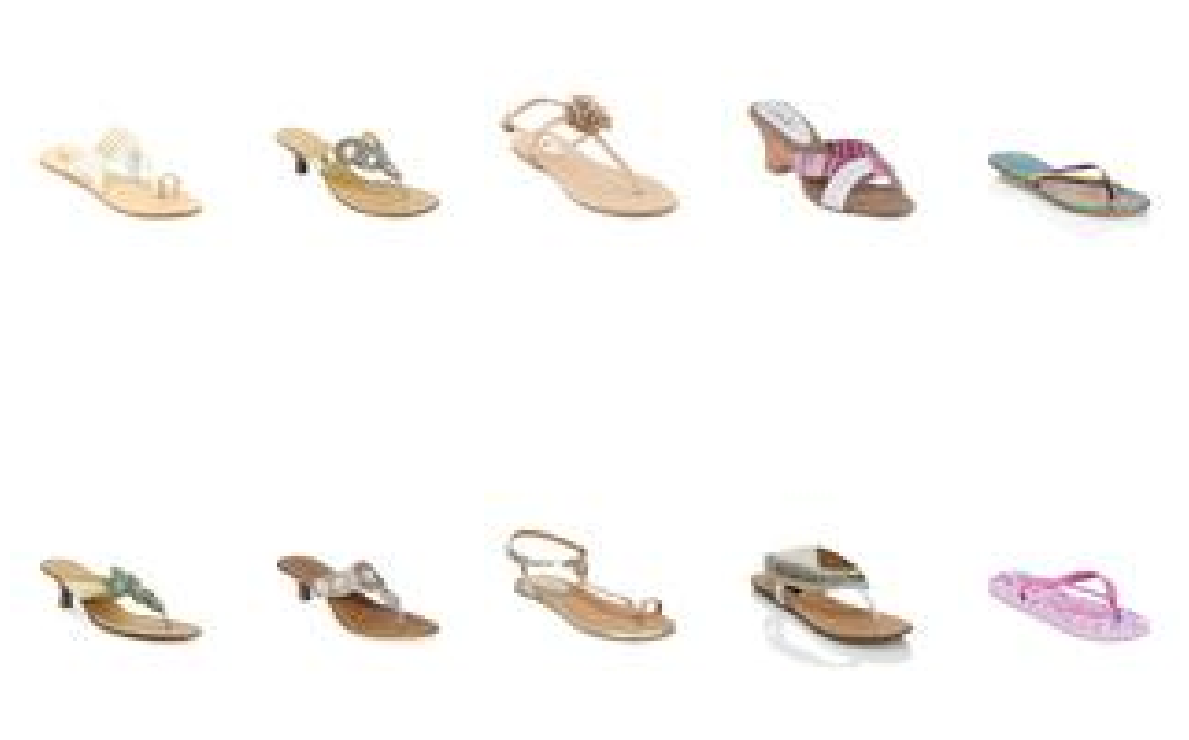

In [51]:
from PIL import Image
import matplotlib.pyplot as plt


num_rows = 2
num_columns = 5
total_images = num_rows * num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

for i, example in enumerate(filtered_dataset):
    if i >= total_images:
        break

    row = i // num_columns
    col = i % num_columns

    image_bytes = example["image"]


    axes[row, col].imshow(image_bytes)
    axes[row, col].axis('off')

# Fill any remaining empty subplots with blank images
for i in range(len(filtered_dataset), total_images):
    row = i // num_columns
    col = i % num_columns
    blank_image = np.zeros((100, 100, 3), dtype=np.uint8)  # Creating a blank black image
    axes[row, col].imshow(blank_image)
    axes[row, col].axis('off')

# Adjust spacing and layout
plt.tight_layout()
plt.show()